## Discretization Task

### Import packages

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import ngrams
import nltk
import itertools

### 1. Discretize using percentiles

In [195]:
dataset03 = pd.read_csv("dataset/BATADAL_dataset03.csv",index_col="DATETIME")
dataset03.index = pd.to_datetime(dataset03.index)
dataset03.columns

Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')

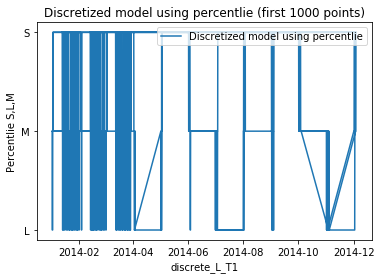

In [7]:
def discretize(a):
    # first find q1
    q = 25
    q1 = np.percentile(a,q,axis=0,interpolation ='linear')
    # and then find q2
    q = 75
    q3 = np.percentile(a,q,axis=0,interpolation ='linear')

    # anything below q1 is "S", anything between q1 and q3 is "M", and anything over q3 is "L"
    discrete = []
    for x in a:
        if x <= q1:
            discrete.append("S")
        elif x > q1 and x < q3:
            discrete.append("M")
        elif x >= q3:
            discrete.append("L")
            
    return discrete


# plt.figure()
# dataset03['L_T1'].plot(marker="o")
# dataset03['L_T1'].describe()
# plt.axhline(y=q1,linestyle='--',label=".25 percentile")
# plt.axhline(y=q3,linestyle='--',label=".75 percentile")

dataset03['discrete_L_T1'] = discretize(dataset03['L_T1'])
dataset03['discrete_L_T1']
plt.figure()
plt.plot(dataset03['discrete_L_T1'][:2000], label='Discretized model using percentlie') 
plt.title("Discretized model using percentlie (first 1000 points)")
plt.legend(loc ='upper right')
plt.xlabel('discrete_L_T1')
plt.ylabel('Percentlie S,L,M')
plt.show()

In [8]:
dataset03['discrete_L_T1'].value_counts()

M    4379
S    2191
L    2191
Name: discrete_L_T1, dtype: int64

### 2. Compute Conditional Probability of Trigrams 
We try to compute the trigrams (N-gram with N=3) conditional probability

In [9]:
trigrams = ngrams(dataset03['discrete_L_T1'], 3)

In [10]:
trigrams_list = []
for w0,w1,w2 in trigrams:
  trigrams_list.append((w0,w1,w2))

In [12]:
condition_pairs = [((w0, w1), w2) for w0, w1, w2 in trigrams_list]
cfd = nltk.ConditionalFreqDist(condition_pairs)
cpd_mle = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist, bins=3)

In [13]:
possible_permutations = [subset for subset in itertools.product(['S','M','L'], repeat=3)]
possible_permutations

[('S', 'S', 'S'),
 ('S', 'S', 'M'),
 ('S', 'S', 'L'),
 ('S', 'M', 'S'),
 ('S', 'M', 'M'),
 ('S', 'M', 'L'),
 ('S', 'L', 'S'),
 ('S', 'L', 'M'),
 ('S', 'L', 'L'),
 ('M', 'S', 'S'),
 ('M', 'S', 'M'),
 ('M', 'S', 'L'),
 ('M', 'M', 'S'),
 ('M', 'M', 'M'),
 ('M', 'M', 'L'),
 ('M', 'L', 'S'),
 ('M', 'L', 'M'),
 ('M', 'L', 'L'),
 ('L', 'S', 'S'),
 ('L', 'S', 'M'),
 ('L', 'S', 'L'),
 ('L', 'M', 'S'),
 ('L', 'M', 'M'),
 ('L', 'M', 'L'),
 ('L', 'L', 'S'),
 ('L', 'L', 'M'),
 ('L', 'L', 'L')]

In [14]:
for (a,b,c) in possible_permutations:
    print ("P(",c,"|",a,",",b,") =",cpd_mle[(a,b)].prob(b))

P( S | S , S ) = 0.903420523138833
P( M | S , S ) = 0.903420523138833
P( L | S , S ) = 0.903420523138833
P( S | S , M ) = 0.9901477832512315
P( M | S , M ) = 0.9901477832512315
P( L | S , M ) = 0.9901477832512315
P( S | S , L ) = 0
P( M | S , L ) = 0
P( L | S , L ) = 0
P( S | M , S ) = 0.9455445544554455
P( M | M , S ) = 0.9455445544554455
P( L | M , S ) = 0.9455445544554455
P( S | M , M ) = 0.8745815091424156
P( M | M , M ) = 0.8745815091424156
P( L | M , M ) = 0.8745815091424156
P( S | M , L ) = 0.9554794520547946
P( M | M , L ) = 0.9554794520547946
P( L | M , L ) = 0.9554794520547946
P( S | L , S ) = 0
P( M | L , S ) = 0
P( L | L , S ) = 0
P( S | L , M ) = 0.9828767123287672
P( M | L , M ) = 0.9828767123287672
P( L | L , M ) = 0.9828767123287672
P( S | L , L ) = 0.8530805687203792
P( M | L , L ) = 0.8530805687203792
P( L | L , L ) = 0.8530805687203792


In [15]:
# with laplace smoothing
cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=3)

In [157]:
for (a,b,c) in possible_permutations:
    print ("P(",c,"|",a,",",b,") =",cpd_laplace[(a,b)].prob(c))

P( S | S , S ) = 0.8965753424657534
P( M | S , S ) = 0.1023972602739726
P( L | S , S ) = 0.0010273972602739725
P( S | S , M ) = 0.0219435736677116
P( M | S , M ) = 0.9717868338557993
P( L | S , M ) = 0.006269592476489028
P( S | S , L ) = 0.2
P( M | S , L ) = 0.2
P( L | S , L ) = 0.6
P( S | M , S ) = 0.9369085173501577
P( M | M , S ) = 0.05993690851735016
P( L | M , S ) = 0.0031545741324921135
P( S | M , M ) = 0.0540398740818468
P( M | M , M ) = 0.872158097236796
P( L | M , M ) = 0.07380202868135712
P( S | M , L ) = 0.002277904328018223
P( M | M , L ) = 0.05239179954441914
P( L | M , L ) = 0.9453302961275627
P( S | L , S ) = 0.7142857142857143
P( M | L , S ) = 0.14285714285714285
P( L | L , S ) = 0.14285714285714285
P( S | L , M ) = 0.002288329519450801
P( M | L , M ) = 0.9633867276887872
P( L | L , M ) = 0.034324942791762014
P( S | L , L ) = 0.001785076758300607
P( M | L , L ) = 0.14744734023563014
P( L | L , L ) = 0.8507675830060693


### 3. Sliding windows on dataset04

In [17]:
dataset04 = pd.read_csv("dataset/BATADAL_dataset04.csv",index_col="DATETIME")
dataset04.index = pd.to_datetime(dataset04.index)
dataset04.sort_index(inplace=True)
dataset04.columns = [x.strip() for x in dataset04.columns]
dataset04.columns

Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')

In [18]:
dataset04['discrete_L_T1'] = discretize(dataset04['L_T1'])

In [19]:
window_size = 3
threshold = 0.005

samples = dataset03['discrete_L_T1']
#init conditional probabilities
condition_pairs = [((w0, w1), w2) for w0, w1, w2 in ngrams(samples,window_size)]
cfd = nltk.ConditionalFreqDist(condition_pairs)
cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=window_size)

# sliding windows
samples = samples.append(dataset04['discrete_L_T1'][:window_size])
anomalies = [0] * window_size
for t in range(window_size,len(dataset04['discrete_L_T1'])):
    print("t=",t)
    # calculate probability
    a,b,c = dataset04['discrete_L_T1'][t-window_size:t]
    if (cpd_laplace[(a,b)].prob(c) < threshold):
        print ("ANOMALY DETECTED")
        anomalies.append(1) # raise alarm
    else:
        anomalies.append(0)
    
    samples = samples.append(dataset04['discrete_L_T1'][t-1:t])
    condition_pairs = [((w0, w1), w2) for w0, w1, w2 in ngrams(samples,window_size)]
    cfd = nltk.ConditionalFreqDist(condition_pairs)
    cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=window_size)

t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17
t= 18
t= 19
t= 20
t= 21
t= 22
t= 23
t= 24
t= 25
t= 26
t= 27
t= 28
t= 29
t= 30
t= 31
t= 32
t= 33
t= 34
t= 35
t= 36
t= 37
t= 38
t= 39
t= 40
t= 41
t= 42
t= 43
t= 44
t= 45
t= 46
t= 47
t= 48
t= 49
t= 50
ANOMALY DETECTED
t= 51
t= 52
t= 53
t= 54
t= 55
t= 56
t= 57
t= 58
t= 59
t= 60
t= 61
t= 62
t= 63
t= 64
t= 65
t= 66
t= 67
t= 68
t= 69
t= 70
t= 71
t= 72
t= 73
t= 74
t= 75
t= 76
t= 77
t= 78
t= 79
t= 80
t= 81
t= 82
t= 83
t= 84
t= 85
t= 86
t= 87
t= 88
t= 89
t= 90
t= 91
t= 92
t= 93
t= 94
t= 95
t= 96
t= 97
t= 98
t= 99
t= 100
t= 101
t= 102
t= 103
t= 104
t= 105
t= 106
t= 107
t= 108
t= 109
t= 110
t= 111
t= 112
t= 113
t= 114
t= 115
t= 116
t= 117
t= 118
t= 119
t= 120
t= 121
t= 122
t= 123
t= 124
t= 125
t= 126
t= 127
t= 128
t= 129
t= 130
t= 131
t= 132
t= 133
t= 134
t= 135
t= 136
t= 137
t= 138
t= 139
t= 140
t= 141
t= 142
t= 143
t= 144
t= 145
t= 146
t= 147
t= 148
t= 149
t= 150
t= 151
t= 152
t= 153
t= 154
t= 155
t= 156
t= 157
t=

t= 1157
t= 1158
t= 1159
t= 1160
t= 1161
t= 1162
t= 1163
t= 1164
t= 1165
t= 1166
t= 1167
t= 1168
t= 1169
t= 1170
t= 1171
t= 1172
t= 1173
t= 1174
t= 1175
t= 1176
t= 1177
t= 1178
t= 1179
t= 1180
t= 1181
t= 1182
t= 1183
t= 1184
t= 1185
t= 1186
t= 1187
t= 1188
t= 1189
t= 1190
t= 1191
t= 1192
t= 1193
t= 1194
t= 1195
t= 1196
t= 1197
t= 1198
t= 1199
t= 1200
t= 1201
t= 1202
t= 1203
t= 1204
t= 1205
t= 1206
t= 1207
t= 1208
t= 1209
t= 1210
t= 1211
t= 1212
t= 1213
t= 1214
t= 1215
t= 1216
t= 1217
t= 1218
t= 1219
t= 1220
t= 1221
t= 1222
t= 1223
t= 1224
t= 1225
t= 1226
t= 1227
t= 1228
t= 1229
t= 1230
t= 1231
t= 1232
t= 1233
t= 1234
t= 1235
t= 1236
t= 1237
t= 1238
t= 1239
t= 1240
t= 1241
t= 1242
t= 1243
t= 1244
t= 1245
t= 1246
t= 1247
t= 1248
t= 1249
t= 1250
t= 1251
t= 1252
t= 1253
t= 1254
t= 1255
t= 1256
t= 1257
t= 1258
t= 1259
t= 1260
t= 1261
t= 1262
t= 1263
t= 1264
t= 1265
t= 1266
t= 1267
t= 1268
t= 1269
t= 1270
t= 1271
t= 1272
t= 1273
t= 1274
t= 1275
t= 1276
t= 1277
t= 1278
t= 1279
t= 1280
t= 1281


t= 2187
t= 2188
t= 2189
t= 2190
t= 2191
t= 2192
t= 2193
t= 2194
t= 2195
t= 2196
t= 2197
t= 2198
t= 2199
t= 2200
t= 2201
t= 2202
t= 2203
t= 2204
t= 2205
t= 2206
t= 2207
t= 2208
t= 2209
t= 2210
t= 2211
t= 2212
t= 2213
t= 2214
t= 2215
t= 2216
t= 2217
t= 2218
t= 2219
t= 2220
t= 2221
t= 2222
t= 2223
t= 2224
t= 2225
t= 2226
t= 2227
t= 2228
t= 2229
t= 2230
t= 2231
t= 2232
t= 2233
t= 2234
t= 2235
t= 2236
t= 2237
t= 2238
t= 2239
t= 2240
t= 2241
t= 2242
t= 2243
t= 2244
t= 2245
t= 2246
t= 2247
t= 2248
t= 2249
t= 2250
t= 2251
t= 2252
t= 2253
t= 2254
t= 2255
t= 2256
t= 2257
t= 2258
t= 2259
t= 2260
t= 2261
t= 2262
t= 2263
t= 2264
t= 2265
t= 2266
t= 2267
t= 2268
t= 2269
t= 2270
t= 2271
t= 2272
t= 2273
t= 2274
t= 2275
t= 2276
t= 2277
t= 2278
t= 2279
t= 2280
t= 2281
t= 2282
t= 2283
t= 2284
t= 2285
t= 2286
t= 2287
t= 2288
t= 2289
t= 2290
t= 2291
t= 2292
t= 2293
t= 2294
t= 2295
t= 2296
t= 2297
t= 2298
t= 2299
t= 2300
t= 2301
t= 2302
t= 2303
t= 2304
t= 2305
t= 2306
t= 2307
t= 2308
t= 2309
t= 2310
t= 2311


t= 3213
t= 3214
t= 3215
t= 3216
t= 3217
t= 3218
t= 3219
t= 3220
t= 3221
t= 3222
t= 3223
t= 3224
t= 3225
t= 3226
t= 3227
t= 3228
t= 3229
t= 3230
t= 3231
t= 3232
t= 3233
t= 3234
t= 3235
t= 3236
t= 3237
t= 3238
t= 3239
t= 3240
t= 3241
t= 3242
t= 3243
t= 3244
t= 3245
t= 3246
t= 3247
t= 3248
t= 3249
t= 3250
t= 3251
t= 3252
t= 3253
t= 3254
t= 3255
t= 3256
t= 3257
t= 3258
t= 3259
t= 3260
t= 3261
t= 3262
t= 3263
t= 3264
t= 3265
t= 3266
t= 3267
t= 3268
t= 3269
t= 3270
t= 3271
t= 3272
t= 3273
t= 3274
t= 3275
t= 3276
t= 3277
t= 3278
t= 3279
t= 3280
t= 3281
t= 3282
t= 3283
t= 3284
t= 3285
t= 3286
t= 3287
t= 3288
t= 3289
t= 3290
t= 3291
t= 3292
t= 3293
t= 3294
t= 3295
t= 3296
t= 3297
t= 3298
t= 3299
t= 3300
t= 3301
t= 3302
t= 3303
t= 3304
t= 3305
t= 3306
t= 3307
t= 3308
t= 3309
t= 3310
t= 3311
t= 3312
t= 3313
t= 3314
t= 3315
t= 3316
t= 3317
t= 3318
t= 3319
t= 3320
t= 3321
t= 3322
t= 3323
t= 3324
t= 3325
t= 3326
t= 3327
t= 3328
t= 3329
t= 3330
t= 3331
t= 3332
t= 3333
t= 3334
t= 3335
t= 3336
t= 3337


In [25]:
pd.Series(anomalies).value_counts()
# 7 anomalies in dataset04

0    4170
1       7
dtype: int64

In [26]:
anomalies = pd.Series(anomalies)
anomalies.index = dataset04['L_T1'].index

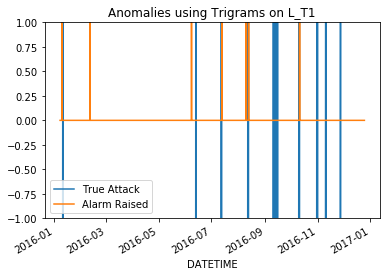

In [27]:
axes = plt.gca()
axes.set_ylim([-1,1])
plt.plot(dataset04['ATT_FLAG'], label="True Attack")
anomalies.plot(label="Alarm Raised")
plt.title("Anomalies using Trigrams on L_T1")
plt.legend()

### Build models for other sensors

In [28]:
# list the sensors column
sensors = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'F_PU2', 'F_PU3', 'F_PU4', 'F_PU5', 'F_PU6', 'F_PU7', 'F_PU8', 'F_PU9', 'F_PU10', 'F_PU11', 'F_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

In [29]:
# function to build anomaly detection model using n-gram
def detect_anomalies_n_gram(train, test, sensor, window_size=3, threshold=0.005):
    train['discrete_'+sensor] = discretize(train[sensor])
    test['discrete_'+sensor] = discretize(test[sensor])
    
    samples = train['discrete_'+sensor]
    #init conditional probabilities
    condition_pairs = [((w0, w1), w2) for w0, w1, w2 in ngrams(samples,window_size)]
    cfd = nltk.ConditionalFreqDist(condition_pairs)
    cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=window_size)

    # sliding windows
    samples = samples.append(test['discrete_'+sensor][:window_size])
    anomalies = [0] * window_size
    for t in range(window_size,len(test['discrete_'+sensor])):
        # calculate probability
        a,b,c = test['discrete_L_T1'][t-window_size:t]
        if (cpd_laplace[(a,b)].prob(c) < threshold):
            anomalies.append(1) # raise alarm
        else:
            anomalies.append(0)

        samples = samples.append(test['discrete_'+sensor][t-1:t])
        condition_pairs = [((w0, w1), w2) for w0, w1, w2 in ngrams(samples,window_size)]
        cfd = nltk.ConditionalFreqDist(condition_pairs)
        cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=window_size)
        
    anomalies = pd.Series(anomalies)
    anomalies.index = test[sensor].index
    
    return anomalies

In [175]:
# the code in this cell will take some time. you can skip this and instead run the cell after this
anomaly_detection = pd.DataFrame()
for sensor in sensors[1:]: 
    print("Building anomaly detection model for ",sensor)
    anomaly_detection[sensor] = detect_anomalies_n_gram(dataset03, dataset04, sensor)

anomaly_detection.index = dataset04.index
anomaly_detection.to_csv("output/anomalies_trigrams.csv") # save to file

Building anomaly detection model for  L_T2
Building anomaly detection model for  L_T3
Building anomaly detection model for  L_T4
Building anomaly detection model for  L_T5
Building anomaly detection model for  L_T6
Building anomaly detection model for  L_T7
Building anomaly detection model for  F_PU1
Building anomaly detection model for  F_PU2
Building anomaly detection model for  F_PU3
Building anomaly detection model for  F_PU4
Building anomaly detection model for  F_PU5
Building anomaly detection model for  F_PU6
Building anomaly detection model for  F_PU7
Building anomaly detection model for  F_PU8
Building anomaly detection model for  F_PU9
Building anomaly detection model for  F_PU10
Building anomaly detection model for  F_PU11
Building anomaly detection model for  F_V2
Building anomaly detection model for  P_J280
Building anomaly detection model for  P_J269
Building anomaly detection model for  P_J300
Building anomaly detection model for  P_J256
Building anomaly detection model 

In [32]:
# the code from the previous cell will take some time, you can instead uncomment the following to load from file
anomaly_detection = pd.read_csv("output/anomalies_trigrams.csv", index_col="DATETIME")
anomaly_detection.index = dataset04.index

C:\Users\Nivedita Prasad\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


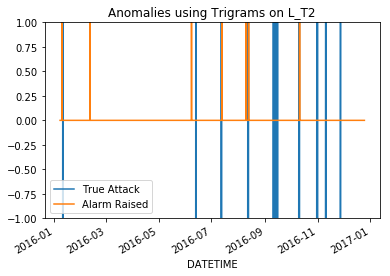

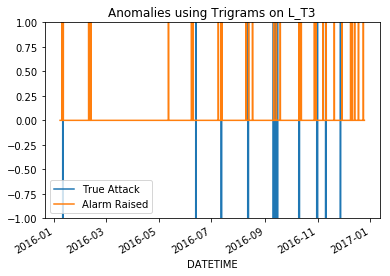

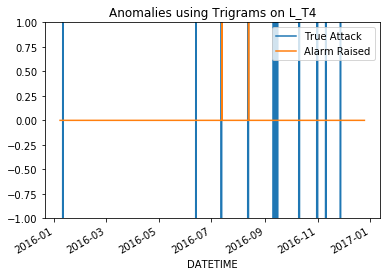

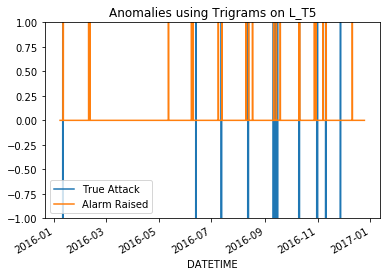

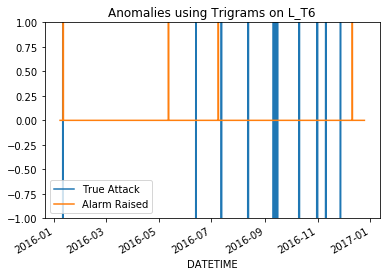

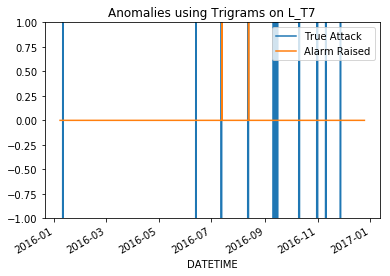

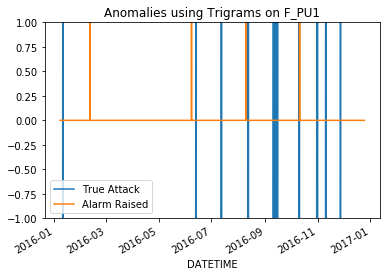

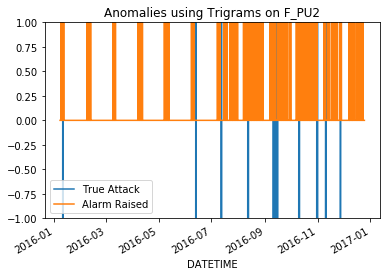

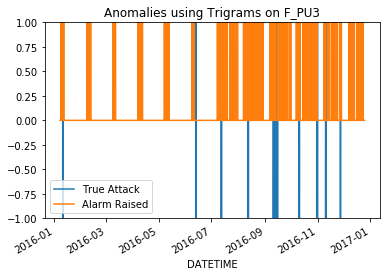

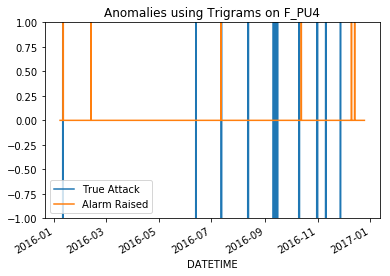

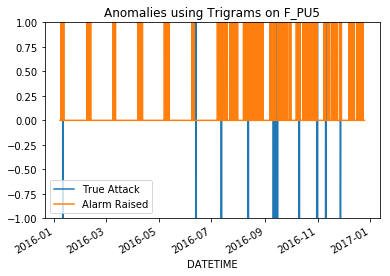

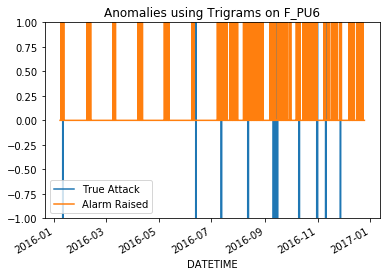

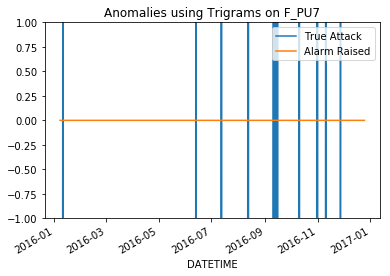

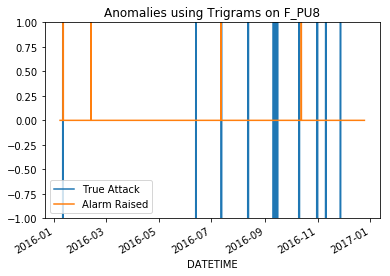

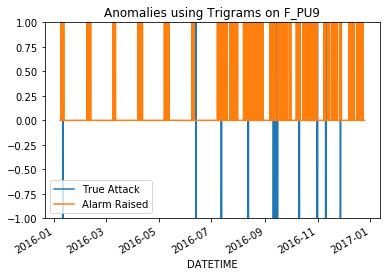

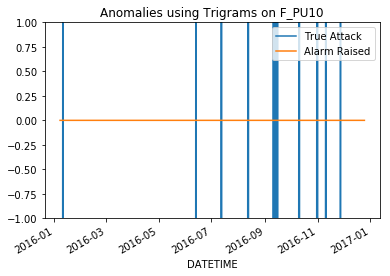

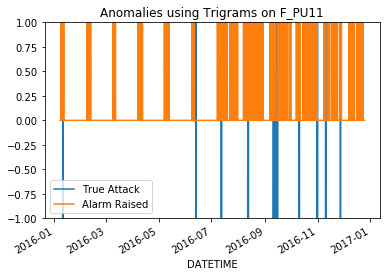

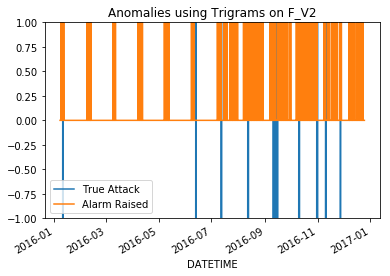

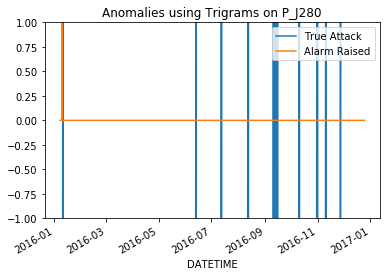

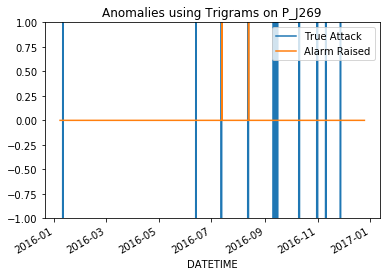

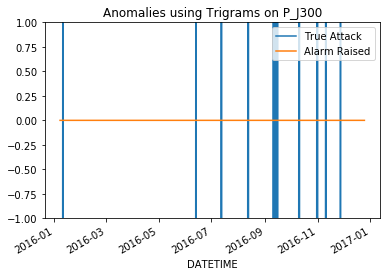

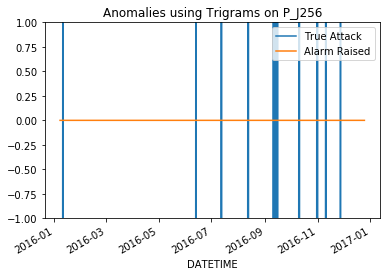

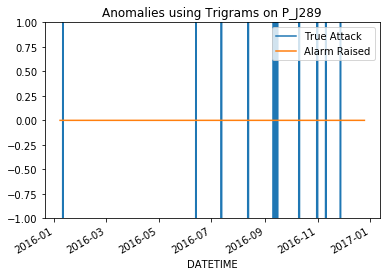

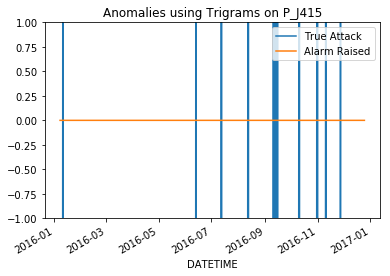

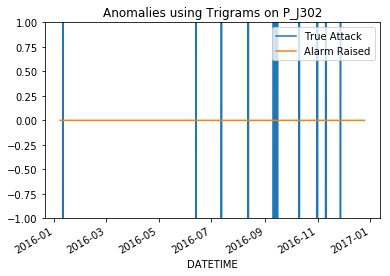

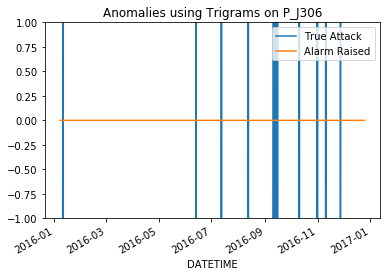

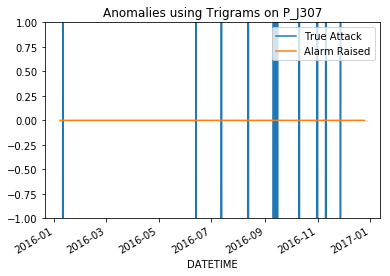

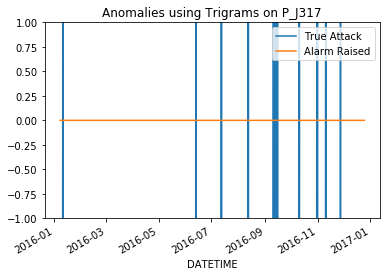

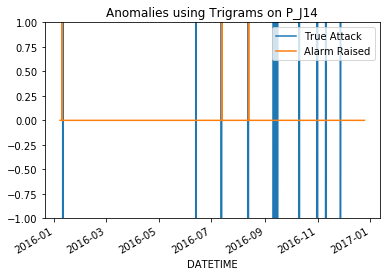

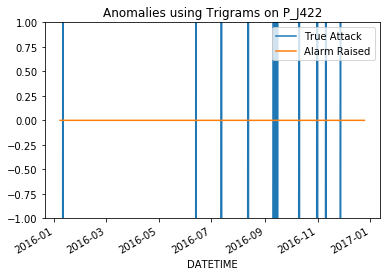

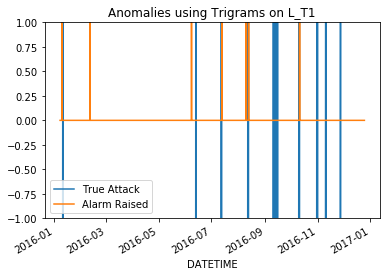

In [33]:
for sensor in anomaly_detection.keys():
    plt.figure()
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(dataset04['ATT_FLAG'], label="True Attack")
    anomaly_detection[sensor].plot(label="Alarm Raised")
    plt.title("Anomalies using Trigrams on "+sensor)
    plt.legend()

In [37]:
for sensor in anomaly_detection.keys():
    print(sensor,'Anomaly count is : ')
    print(anomaly_detection[sensor].value_counts())
# 0 is not an anomaly; wherease 1 is anomaly in dataset04

L_T2 Anomaly count is : 
0    4170
1       7
Name: L_T2, dtype: int64
L_T3 Anomaly count is : 
0    4141
1      36
Name: L_T3, dtype: int64
L_T4 Anomaly count is : 
0    4175
1       2
Name: L_T4, dtype: int64
L_T5 Anomaly count is : 
0    4154
1      23
Name: L_T5, dtype: int64
L_T6 Anomaly count is : 
0    4173
1       4
Name: L_T6, dtype: int64
L_T7 Anomaly count is : 
0    4175
1       2
Name: L_T7, dtype: int64
F_PU1 Anomaly count is : 
0    4173
1       4
Name: F_PU1, dtype: int64
F_PU2 Anomaly count is : 
0    4063
1     114
Name: F_PU2, dtype: int64
F_PU3 Anomaly count is : 
0    4069
1     108
Name: F_PU3, dtype: int64
F_PU4 Anomaly count is : 
0    4170
1       7
Name: F_PU4, dtype: int64
F_PU5 Anomaly count is : 
0    4069
1     108
Name: F_PU5, dtype: int64
F_PU6 Anomaly count is : 
0    4069
1     108
Name: F_PU6, dtype: int64
F_PU7 Anomaly count is : 
0    4177
Name: F_PU7, dtype: int64
F_PU8 Anomaly count is : 
0    4173
1       4
Name: F_PU8, dtype: int64
F_PU9 Anomaly 